#### _Speech Processing Labs: SIGNALS 1: Digital Speech Signals_

In [7]:
## Press shift-enter to run this first! or else press the Run button when running on a notebook server
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import cmath
from math import floor
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display, Audio
plt.style.use('ggplot')

from numpy.fft import fft
!pip install numpy==1.24


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 9.5 MB/s eta 0:00:000m eta 0:00:010:01:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.0
    Uninstalling numpy-1.25.0:
      Successfully uninstalled numpy-1.25.0
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: Could not install packages due to an OSError: [Errno 16] Device or resource busy: '.__afs86E9'



# Working with Digital Signals

## Learning Outcomes

* Understand how spectrograms relate to the Discrete Fourier Transform
* Understand how DFT output is affected by design choices, e.g., input window size, sampling rate, windowing type
* Understand how how digital signals can be combined through superposition
* Understand how spectral leakage can affect spectrograms
* Understand how aliasing can affect digital sound recordings
* See how digital signals can be can be visualised using a range of plot types

## Background

* Speech Zone Module 3 videos: up to and including [Frequency Domain](https://speech.zone/courses/speech-processing/module-3-digital-speech-signals/)
* Reading: R. Waytree (2019) Phonetics: a practical perspective, Chapters 6 and 7


## A Note on coding

The code below and throughout these notebooks is for generating visualisations, to show some concrete steps for doing this sort of analysis, and to allow you to alter parameters and see what the effect is.  But for this course, you don't have to understand every line of code unless you really want to. It's fine just to run the code and look at the output. 

Extension: If you have some python experience, you can try coding up some of the cells below yourself!    

# Plotting waveforms and spectrograms in python

You've seen a spectrogram in Praat, but you can also do this in python! This might be helpful for you later on when writing reports. 

In this notebook, we'll use the general purpose python package [matplotlib](https://matplotlib.org) to make plots.  To handle audio data we'll use the [librosa](https://librosa.org/doc/latest/index.html) package. Matplotlib is pre-installed in the [Edina Noteable](https://noteable.edina.ac.uk/resources/) standard notebook, but librosa isn't.  We can install it now using the commanding the next cell:


## Install and import Librosa

The following code cell will install the librosa package into your current python environment 

Breaking it down: 
The `!` at the beginning of the line tells jupyter notebook to run the command that follows as if it's on the unix shell (i.e., on the command line).  [`pip`](https://pypi.org/project/pip/) is a command line program that can install python packages (i.e., code collections) for you.  So, the command `pip install librosa` installs the package librosa for us.  If it's already installed it'll give you several "requirement already satisfied" messages. 

In [2]:
!pip install librosa

Defaulting to user installation because normal site-packages is not writeable




Now to use `librosa` in the notebook we need to import it (as we did for various packages up the top). 

In [3]:
import librosa

## Load a sound file with librosa

Now let's [load a sound file](https://librosa.org/doc/latest/generated/librosa.load.html) that's already in our repo and make a html audio widget to play it in the notebook. 
It's a short recording of a violin playing a single note.  

Note, in the python cells below lines starting with `#` are comments: They are explanations and ignored when running the code. 

In [9]:
## Set the variable 'filename' to the path of the file
## You can read the file path as directions for how to get to the file: 
## i.e., ".." = up a directory, then into the 'sounds' directory, then the actual filename
filename = "../sounds/violin_A4_05_forte_arco-normal.mp3"

## Load the waveform amplitudes y from the file and also get the sampling rate sr
y, sr = librosa.load(filename)

## Make an html audio widget so you can listen to the audio from this notebook
Audio(data=y, rate=sr)

We've loaded the mp3 file and returned two outputs, which are stored in the variables `y` and `sr`:
* `y`: The waveform (i.e. amplitude sequence)
* `sr`: The sampling rate of the recording - this will have the value 22050 Hz. 

**Task:** Try changing the sample rate in the following while keeping `y` the same.  


In [10]:
## Inspect the value of the variable sr
sr

22050

In [11]:
## Make an audio widget that plays y but change the sample rate to 16000
## Uncomment the following line by deleting the "#" at the beginning and change XXXX to the 
## sample rate you want
Audio(data=y, rate=44100)

**Question:** What happened when you changed the sampling rate? What about the sound changed? Why did this happen? 

### Inspecting the audio (and some python warmups)
Let's look at `y` first.  You can inspect the contents of a variable by inputting it as the last line in a code cell and running the cell:

In [12]:
## inspect the y variable that "holds" our waveform 
y

array([-7.2759576e-12,  1.6007107e-10,  4.3655746e-11, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)

You should see a formatted version of an array of numbers (i.e., a list of numbers, but more efficiently represented for our purposes using the package [numpy](https://numpy.org) - a python package that, for our purposes, makes dealing with vectors and matrices easier). These numbers are the amplitude samples that make up the audio recording ordered in time.  

We can access elements of this array by their index, where we start the index at 0.  So: `y[2]` is the 3rd sample in this array, `y[10]` is the 11th samples in the array, etc. 


In [13]:
y[10]

-3.2014214e-10

You should see a number that looks something like `-2.3283064e-10` as the output of the previous cell (since these are very small values there may be some differences in what you actually see - if the sound plays fine, don't worry!).  This is the amplitude value for the 11th sample in scientific notation: the `e-10` is intepreted as `10^{-10}`, so the overall expression is $-2.3283064 \times 10^{-10}$, which is a very small number!  If we round this to 9 decimal places, we'll see python just prints out `-0.0`

In [14]:
round(y[10],9)

-0.0

Now, we can check what sort of array this is and the number of samples in our waveform `y` by checking the 'shape' of the array. We can do this with numpy `shape` attribute:

In [15]:
## inspect y.shape
y.shape

(31104,)

You should see the output `(31104,`) which means that it's a 1 dimensional array of 31104 numbers. The following shows how you can set another variable `nsample` to be the number of number of elements in `y`, and then use that variable to print out a print statement. 

In [16]:
## Set n_samples to the first (0th) value of y.shape.  In a matrix this would be the number of rows
n_samples = y.shape[0]

## print out n_samples
print(f"The number of samples in y is {n_samples}")

The number of samples in y is 31104


The `f"..."` in the print statement tells python to substitute the bits between `{` and `}` with the value of the variable named there.  So in the code above we get value of `n_samples` (31104) in the output of the cell. 


**Task:** Try writing a print statement to see what the sampling rate `sr` is in the following cell

In [17]:
## Add a line here to print out the sampling rate (you can copy the previous print statement as a template) 
sr

22050

You should see that the sampling rate is 22050 samples per second (since we're talking about frequency of sampling, people often just use Hertz as the unit for sampling rate).

We can do basic arithmetic in notebooks using the following symbols
* `+`: addition
* `-`: subtraction/negative
* `*`: multiplication
* `/`: division
* `**`: exponentiation ('to the power of')

For example: running the following cell with the expression `((2**2)*4 + 5)/7` should give you the answer `3`
(if you're not sure why - ask!)

In [18]:
((2**2)*4 + 5)/7

3.0

**Question:** the sampling rate is the number of samples per second (evenly spaced!).  So what is the sampling period? i.e., how long is there between each sample?  

**Task:** Calculate the sample period given the sample rate `sr` we retrieved earlier and store it in the variable `sample_period`.  

_These are just some tasks to get you used to python notebooks.  If you've never done any coding before and are stuck, ask for help!_

In [19]:
## write a statement to calculate the sample period  as 1/sr
sample_period =  1 / sr


## print out the sample period: change XXXXX
print(f"The sample period is {sample_period}")

The sample period is 4.5351473922902495e-05


**Task:** Calculate the total duration of the wavefile based on the sample period `sample_period` and the number of samples in the file `n_samples`

In [20]:
## Calculate the duration of the waveform: fill in XXX below
duration = sample_period * n_samples
print(f"The duration of y is {duration} seconds")

The duration of y is 1.4106122448979592 seconds


## Visualising the waveform
Now let's make a visualisation of the waveform as a time vs amplitude plot. Remember that our array `y` only included the amplitude values ordered in time. So, we need to figure out what the actual time values are based on the sampling period, which we worked out above from the sampling rate `sr`.  


In [21]:
# We divide 1 second by the number of samples per second to get the sampling period
# we use ":.10f" to format the sample_period to 10 decimal places.
sample_period = 1/sr
print(f"The time between samples is  {sample_period:.10f} seconds")

The time between samples is  0.0000453515 seconds


Lucky for us, librosa figures out sample times for us when we use the function `waveshow`.  This just plots the times vs the amplitudes stored in `y`, but it has some waveform specifics that make what's happening a bit clearer (and prettier?) than the default matplotlib plot function (which we'll use later).   

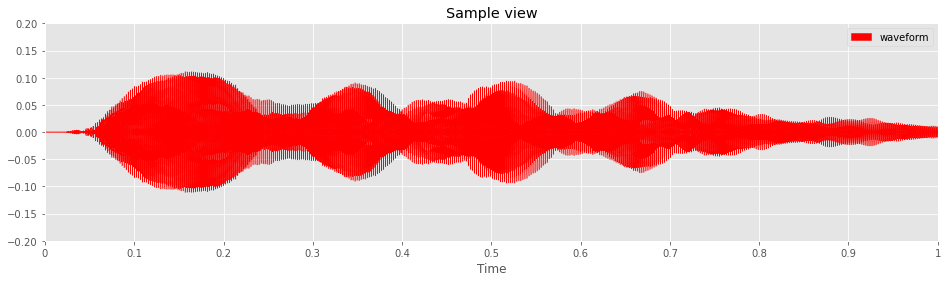

In [22]:
## Create a matplotlib plot - yes, matplotlib syntax is unintuitive! But it's the most 
## widely used python plotting package out there, so worth knowing a bit about. 
## try changing the numbers in setting figsize to see what that does

fig, ax = plt.subplots(figsize=(16,4))

## set some parameters about the plot:
## xlim: the range of the x-axis
## ylim: the range of the y-axis
## title: The title of the plot
ax.set(xlim=[0.0, 1.0], title='Sample view', ylim=[-0.2, 0.2])

## Make the actual time vs amplitude plot
librosa.display.waveshow(y, sr=sr, ax=ax, color='red', label='waveform')

## include the automatically generated legend, though this is not very informative at the moment! 
ax.legend()


**Task:** change the values for `xlim` and `ylim` to zoom into the waveform until you can see some actual pitch periods. What is the F0 of this waveform? (You can calculate it the same way as for the Praat labs, count the number of cycles for a given time interval to find out the time of one cycle).

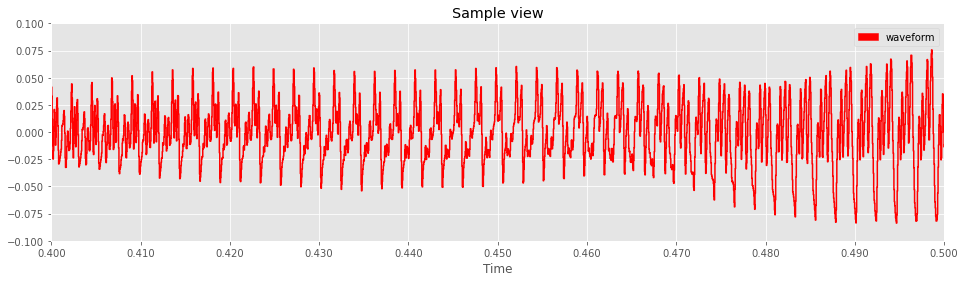

In [25]:
fig, ax = plt.subplots(figsize=(16,4))

ax.set(xlim=[0.4, 0.5], title='Sample view', ylim=[-0.1, 0.1])

## Make the actual time vs amplitude plot
librosa.display.waveshow(y, sr=sr, ax=ax, color='red', label='waveform')

## include the automatically generated legend, though this is not very informative at the moment! 
ax.legend()

### Plot the spectrogram 

Now let's look at a spectrogram.  To generate a spectrogram we apply the DFT to the sequence of frames (i.e. DFT input windows) from the waveform.

We do this with the [librosa function stft](https://librosa.org/doc/latest/generated/librosa.stft.html#librosa.stft) (short-time fourier transform). To get the magnitude spectrum, we take absolute value of the DFT output.


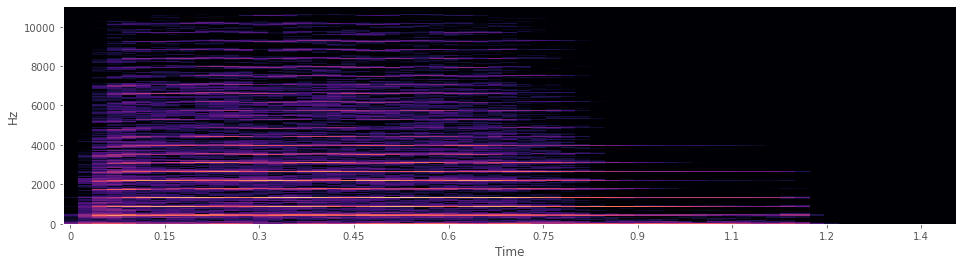

In [26]:
## Apply the DFT over frames through the waveform
y_stft = librosa.stft(y)

## Get the magnitude spectrum by take the absolute value of the DFT output at each frame
mags = np.abs(y_stft)

## Setup a plot
fig, ax = plt.subplots(figsize=(16,4))

## plot the spectogram, showing the y_axis (frequencies) on a linear scale. 
librosa.display.specshow(librosa.amplitude_to_db(mags, ref=np.max), y_axis='linear', x_axis='time', ax=ax)



You should be able to see a colored spectrogram with a fairly clear and stable harmonic structure.  But how do we know what the window size was? 

To find this out we need to check the [librosa manual page description of the stft function](https://librosa.org/doc/latest/generated/librosa.stft.html#librosa.stft), specifically the definition of the `n_fft` parameter: 
<blockquote>
The length of the windowed signal after padding with zeros. The number of rows in the STFT matrix D is (1 + n_fft/2). <b>The default value, n_fft=2048 samples</b>, corresponds to a physical duration of 93 milliseconds at a sample rate of 22050 Hz, i.e. the default sample rate in librosa. This value is well adapted for music signals. However, in speech processing, the recommended value is 512, corresponding to 23 milliseconds at a sample rate of 22050 Hz. In any case, we recommend setting n_fft to a power of two for optimizing the speed of the fast Fourier transform (FFT) algorithm.
    
</blockquote>

So, if we don't specify anything, the default size of the input to the DFT is 2048 samples, which is equivalent to 93 milliseconds, when the sampling rate is 22050 Hz (**task:** verify this window size for yourself).  



### Changing the DFT input widow size
Ok, let's look at what happens when we change `n_fft` to the recommended 512 samples for speech processing:


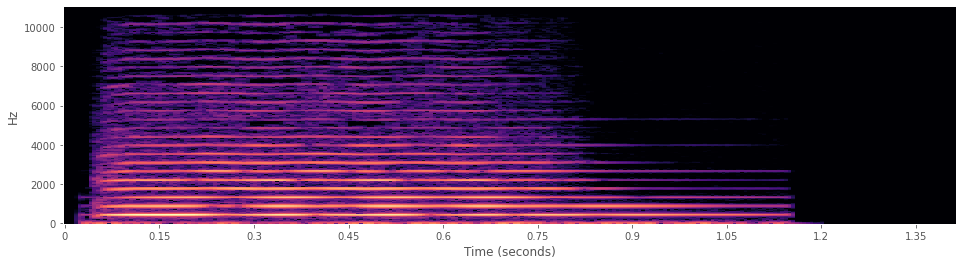

In [27]:

## get the magnitude spectrums using windows of 512*(1/sr) seconds 
N=512
filename = "../sounds/violin_A4_05_forte_arco-normal.wav"
y, sr = librosa.load(filename)
mags = np.abs(librosa.stft(y, n_fft=N))

## plot the spectrogram
## Because we're not using the default n_fft anymore, we also have to tell the specshow function what 
## the hop_length is (i.e. what the shift in time between each window).  
## This is set to n_fft/4 by default in stft 
## (the '//' means return and integer value for the division, to ensure we get a whole number as the hop_length). 
fig, ax = plt.subplots(figsize=(16,4))
librosa.display.specshow(librosa.amplitude_to_db(mags, ref=np.max), sr=sr, n_fft=N, hop_length=N//4,
                         y_axis='linear', x_axis='s', ax=ax)


**Question:** What changed in the spectrogram comparing the orignal with `n_fft=2048` and then with `n_fft=512`?
What are the differences in terms of the visible frequency structure (e.g. formants) and the temporal structure? 




In general, the bigger the DFT input window the more frequency resolution, but this is a tradeoff with the temporal resolution: we see more detail on changes in time with smaller DFT input windows. 

For this specific violin example, the window size change how how well we can see changes in the energy in corresponding to the vibrato (i.e. wobbling of the notes). If we reduce the window size further the individual frequency information will start to blur. Try it out for yourself by changing `N` below! 

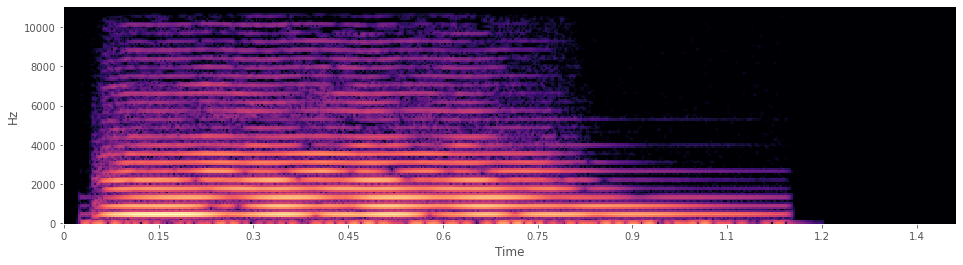

In [31]:
## set the number of samples to include in each input window as N - try N=128 as an example
N=256

## Calculate the magnitude spectrum
mags = np.abs(librosa.stft(y, n_fft=N))

## plot the spectrogram
fig, ax = plt.subplots(figsize=(16,4))
librosa.display.specshow(librosa.amplitude_to_db(mags, ref=np.max), y_axis='linear', x_axis='time', ax=ax, n_fft=N, hop_length=N//4)



## Varying the pitch 

Now let's look at another violin recording of a note at a different pitch: 

In [32]:
## open the file violin_A3_15_forte_arco-normal.mp3 from the sounds directory
filename = "../sounds/violin_A3_15_forte_arco-normal.mp3"

## read in the wave information as y2 
y2, sr2 = librosa.load(filename)

## make an audio widget to play it
Audio(data=y2, rate=sr2)


Let's plot the spectrograms for the two recordings side by side

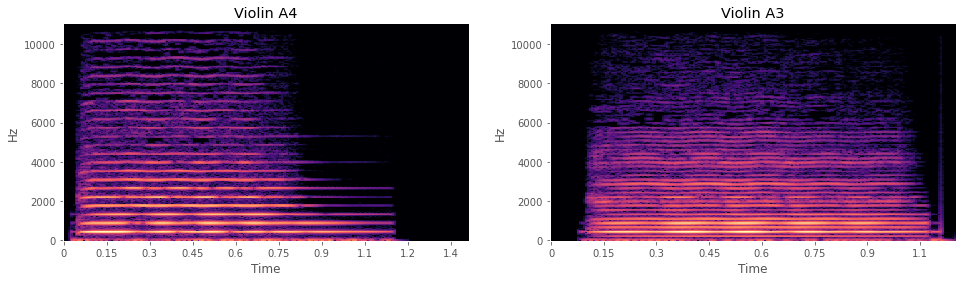

In [33]:
## get the mag spectrums for y2
N=512
mags1 = np.abs(librosa.stft(y, n_fft=N))
mags2 = np.abs(librosa.stft(y2, n_fft=N))

## This time let's make two plots side by side, we can refer to them with the variables ax1 and ax2
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

## Plot the spectrogram of the previous recording in ax1 (left)
ax1.set(title="Violin A4")
librosa.display.specshow(librosa.amplitude_to_db(mags1, ref=np.max), sr=sr, n_fft=N, hop_length=N//4,
                         y_axis='linear', x_axis='time', ax=ax1)

## Plot the spectrogram of the other recording in ax2 (right)
ax2.set(title="Violin A3")
librosa.display.specshow(librosa.amplitude_to_db(mags2, ref=np.max),sr=sr, n_fft=N, hop_length=N//4,
                         y_axis='linear', x_axis='time', ax=ax2)

**Question:** 
What's the main difference in the spectrograms? How is this related to the audible difference in pitch between the two samples? 


### Extracting F0 contours

We can extract Fundamental frequency (F0) values for the two recordings to verify the perceptual relationship between F0 and perceived pitch.  Here we'll use librosa's [F0 extractor which uses the Yin method](https://librosa.org/doc/latest/generated/librosa.pyin.html#librosa.pyin).

In [34]:
## Estimate the fundamental frequency over sliding windows of 512 samples
## We set the minimum potential frequency to 50 Hz, and maximum to 600 Hz.  
## Proper setting of min and max usually necessary to get good F0 estimates for speech research
## though obviously other instruments can go a lot higher or lower. 
N=512
f0_a4, _, _  = librosa.pyin(y=y, sr=sr, fmin=50, fmax=600, frame_length=N)

## Get the times for the f0 samples based on the sample rate
times_a4 = librosa.times_like(f0_a4, sr=sr, hop_length=N//4)

f0_a3, _ , _  = librosa.pyin(y=y2, sr=sr, fmin=50, fmax=600, frame_length=N)
times_a3 = librosa.times_like(f0_a3, sr=sr, hop_length=N//4)


Let's have a look at what this got us for the "A4" recording (`y`, `f0_a4`), versus the "A3" recording (`y2`, `f0_a3`):

In [35]:
f0_a4

array([         nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan, 426.24020065, 431.19287322,
       431.19287322, 433.69074812, 436.20309307, 436.20309307,
       436.20309307, 438.72999188, 438.72999188, 441.27152887,
       441.27152887, 441.27152887, 441.27152887, 441.27152887,
       438.72999188, 438.72999188, 441.27152887, 441.27152887,
       441.27152887, 441.27152887, 441.27152887, 441.27152887,
       441.27152887, 441.27152887, 441.27152887, 441.27152887,
       441.27152887, 441.27152887, 443.82778883, 443.82778883,
       443.82778883, 443.82778883, 443.82778883, 443.82778883,
       443.82778883, 441.27152887, 441.27152887, 441.27152887,
       441.27152887, 441.27152887, 441.27152887, 441.27152887,
       441.27152887, 441.27152887, 441.27152887, 441.27152887,
       441.27152887, 441.27152887, 441.27152887, 441.27152887,
       441.27152887, 441.27152887, 441.27152887, 441.27

In [36]:
f0_a3

array([         nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
       215.59643661, 215.59643661, 216.84537406, 218.10154653,
       218.10154653, 218.10154653, 218.10154653, 218.10154653,
       219.36499594, 219.36499594, 219.36499594, 219.36499594,
       219.36499594, 219.36499594, 219.36499594, 219.36499594,
       219.36499594, 219.36499594, 220.63576443, 220.63576443,
       220.63576443, 220.63576443, 220.63576443, 220.63576443,
       220.63576443, 220.63576443, 220.63576443, 220.63576443,
       220.63576443, 220.63576443, 220.63576443, 220.63576443,
       220.63576443, 220.63576443, 219.36499594, 219.36499594,
       219.36499594, 219.36499594, 219.36499594, 219.36499594,
       219.36499594, 219.36499594, 219.36499594, 219.36

So, the extracted F0 (i.e. pitch) values for the A4 recording are generally around 441 Hz, while the F0 for the A3 recording is around 220 Hz. If you're a musician you will have noticed that they are 1 octave in difference (by definition "A4" should be 440Hz). 

Let's plot the F0 values: 


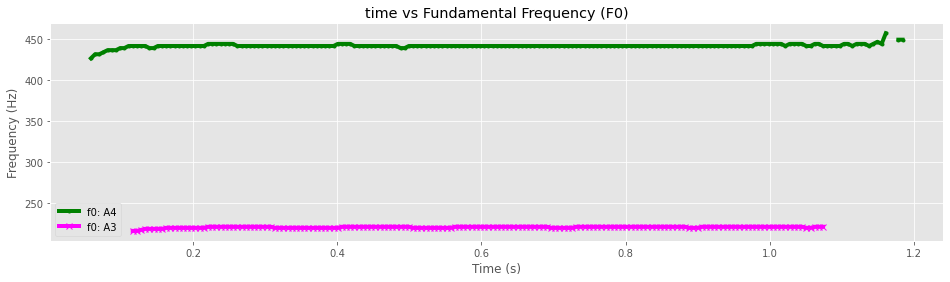

In [37]:
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(times_a4, f0_a4, linewidth=4, color='green', marker=".", label='f0: A4')
ax.plot(times_a3, f0_a3, linewidth=4, color='magenta', marker="x", label='f0: A3')
ax.set(title="time vs Fundamental Frequency (F0)", ylabel="Frequency (Hz)", xlabel="Time (s)")
ax.legend()


So we get what we expect, two slightly wobbly F0 contours at 441Hz and 220Hz. Since they're just holding the one note, this is not very exciting, but we'd expect to see a lot more movement in F0 in human speech! 

### Combining sounds with different fundamental frequencies

So far, all the stuff we have done we can also easily do with Praat.  One thing it's much easier to do in python is manipulate the waveform directly.  It's just an array of numbers!  

We can make a new sound by adding the waveform arrays together time wise. It's very easy to add arrays together in python (with numpy!).  The arrays just have to be the same length.  Since our violin recordings aren't quite the same size, let's just that the first 25000 samples (i.e. `(1/sr)*25000 = ?` seconds).  We can change the relative amplitude of each recording by multiplying the amplitude values by a scaling factor (`1` for both in the following, but you can try changing this)

In [38]:
## Print the overall duration of 25000 samples at sampling rate sr (should be 22050 Hz)
print(f"25000 samples with a sampling rate of {sr} Hz is {(25000/sr)} seconds")

25000 samples with a sampling rate of 22050 Hz is 1.1337868480725624 seconds


In [47]:
# y and y2 together samplewise: 
# i.e. the nth samples of y and y2 are added together to make the first sample of the 
# new combined combined waveform: y_combo[n] = y[n] + y2[n]

y_combo = 1*y[0:25000]+ 10*y2[0:25000]
Audio(data=y_combo, rate=sr)

**Question:** what will the fundamental frequency of the combined signal be? What happens if you make the `y` (the A4~440Hz signal) louder? How does the spectrogram change when you do this? 

**Task:** Change the multipliers for `y` and `y2` above and then use the code below to see how the F0 contour and spectrogram change. 

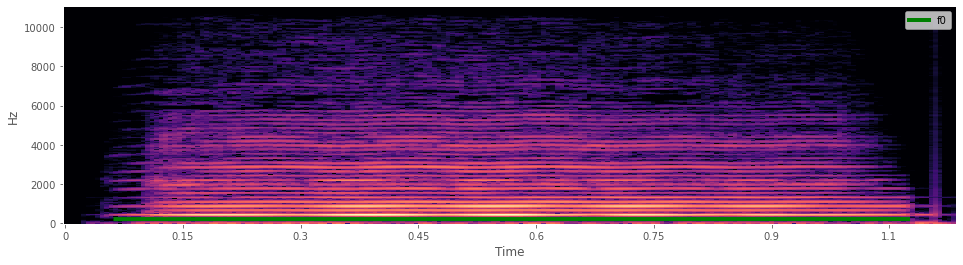

In [48]:
## Set the number of input samples to the F0 tracker and the DFT to 512
N=512

## Get the F0 for y_combo.  You'll see here this function also returns
## some info about voicing that we'll continue to ignore here! 

f0_combo, voicing, voicing_probability = librosa.pyin(y=y_combo, sr=sr, fmin=50, fmax=600, frame_length=N)
times_combo = librosa.times_like(f0_combo, sr=sr, hop_length=N//4)

## Get the magnitude spectrums
mags_combo = np.abs(librosa.stft(y_combo, n_fft=N))

## Set up the plot
fig, ax = plt.subplots(figsize=(16,4))

## Plot the spectrogram
librosa.display.specshow(librosa.amplitude_to_db(mags_combo, ref=np.max), sr=sr, hop_length=N//4,
                         y_axis='linear', x_axis='time', ax=ax)

## Add the F0 contour to the same plot (ax)
ax.plot(times_combo, f0_combo, linewidth=4, color='green',  label='f0')
ax.legend()

# Superposition and DFT Analysis Frequencies


Spectrograms show us how we can use the DFT to analyses the frequency components of a sound waves. This builds on the fact that we create sounds by adding together other sounds.  This addition of waves is often called _superposition_, and is applicable to all sorts of waves (not just sound).

The DFT specifically decomposes waves into [sinusoids](https://mathworld.wolfram.com/Sinusoid.html), i.e. sine (or cosine) waves of varying amplitude, frequency and phase. The frequencies of the sinusoids represented by the DFT output depend on the number of input samples the DFT is given and the sampling rate. 

For an input window containing $N$ samples, recorded at a sampling frequency (aka sampling rate) of $f_s$, the $k$th DFT output is:

<div class="alert alert-success">
    The <b>frequency</b> associated with DFT[k] is: 
    $kf_{min}$ = $kf_s/N$ Hz
</div>

We refer to the frequencies associated with DFT outputs as **analysis frequencies** for a specific DFT setup.  The set of sinusoids with these analysis frequencies forms an **orthogonal basis** that we can use to reconstruct sounds based on a spectrum. The orthogonal basis part means that if we calculate the similarity (~correlation) between any of the sinusoids in the basis, the result will be 0.  

**Question:** The lowest analysis frequency is $f_{min} = f_s/N$.  How many cycles would the sinusoid with frequency $f_{min}$ complete in the time corresponding to $N$ samples (i.e. the length of the input window in seconds). _Hint: calculate the period of $f_{min}$, this will give you the time it takes to complete 1 cycle_




## Some sinusoids, alone and together
Let's load and examine some different sine waves as examples, as well as a wave with a sinusoidal shape but increasing frequency in time.

**Warning:** This sounds might be very loud over headphones.

In [49]:
## file paths to some sine waves of different frequencies as well as 
## a wave with a sinusoidal shape but increasing frequency in time (it'll make sense when you listen to it!)
sine100 = "../sounds/sine_100Hz.wav"
sine200 = "../sounds/sine_200Hz.wav"
sine300 = "../sounds/sine_300Hz.wav"
sweep = "../sounds/sweep.wav"

## Read them into different arrays with librosa

## Note: sr is getting overwritten each time we call load because we keep storing it
## in the same variable "sr".  We don't care hear because we know that they are infact
## all the same sampling rate, but this is something you might need to look out for 
## when dealing with other data.  If sine100 had a different sampling rate to sweep then
## you could get in trouble just using the last updated value of 'sr'

y_100, sr = librosa.load(sine100)
y_200, sr = librosa.load(sine200)
y_300, sr = librosa.load(sine300)
y_sweep, sr = librosa.load(sweep)

## Make audio widgets for each of them 
## We use the 'display' function here to make sure that they all get rendered
## If you don't do this, the notebook will only show the last one

print("Sine wave of 100 Hz")
display(Audio(data=y_100, rate=sr)) # This one is a little hard to hear (for me at least!) but it is there

print("Sine wave of 200 Hz")
display(Audio(data=y_200, rate=sr))

print("Sine wave of 300 Hz")
display(Audio(data=y_300, rate=sr))

print("A frequency sweep")
display(Audio(data=y_sweep, rate=sr))

Sine wave of 100 Hz


Sine wave of 200 Hz


Sine wave of 300 Hz


A frequency sweep


Let's plot the the different sinusoids and verify the frequency differences.  

**Matplotlib note:** The following shows how you can make multiple subplots with the same x-axis so you can easily see the frequency differences.  Here we've set the plot to have 4 rows and 1 column. This means there's multiple axes we can use here captured with the variable `axs`.  We an reference each of these by index (0,1,2,3).  

We plot each of the waveforms into a separate plot, but make sure they all share the same x-axis setting by setting `sharex=True` when calling the function `subplots`. This means that if you change the `xlim` range for `axs[0]` then it will change the bit of the waveform shown for all of the plots. 

Note, we're just using the matplotlib `plot` function here rather than the fancier one from librosa.  This means we need to figure out what the actual timestamps should be for each of the samples ourselves.  We can work this out by making an array representing all the sample indices (0,1,...,the number of samples in `y_200` in this case) and then multiplying them all by the sampling period.  

We can conveniently do this using the numpy function arange.  You should be able to see what this function does by looking at the output of the following cell (`np.arange(10)`)




In [50]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

[(0.0, 0.1)]

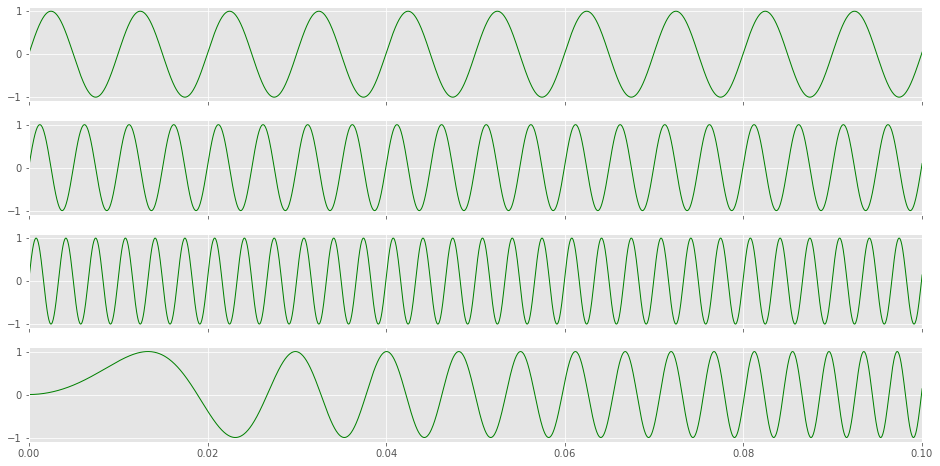

In [51]:
## determine the number of samples and the sampling period
n_samples = len(y_200)
sampling_period = 1/sr

## Create an array of sample indices
sample_indices = np.arange(0,n_samples)

## Get the actual timestamps by multiplying with the sampling_period
ts = sample_indices * sampling_period

## Set up the 4x1 plot
fig, axs = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(16,8))

## Plot the individual sine waves
axs[0].plot(ts, y_100, linewidth=1, color='green', label='waveform')
axs[1].plot(ts, y_200, linewidth=1, color='green', label='waveform')
axs[2].plot(ts, y_300, linewidth=1, color='green', label='waveform')
axs[3].plot(ts, y_sweep, linewidth=1, color='green', label='waveform')

## Set the x-axis limits to 0 and 0.1 - try changing this! 
axs[0].set(xlim=[0,0.1])


With the x-axis range set to (0,0.1) you should be able to see that there are 10 peaks for the 100 Hz sine wave, 20 for the 200 Hz, and 30 for 300 Hz.  For the 'sweep' sound you should see that the peaks get closer together in time, which we perceive as an increase in pitch over time. 

## A compound wave

Now let's add the 100 Hz, 200 Hz, and 300 Hz sine waves together.  
**Question:** What would you expect to see in the spectrogram if we input this combined sound wave? 


In [52]:
## Add the sine waves together
y_sine_combo = y_200 + y_100 + y_300 

## Play the combined wave
display(Audio(data=y_sine_combo, rate=sr))

### Save time, write a function
Copying and pasting code is tedious and makes your code more prone to errors. When you find yourself repeating tasks, you should be thinking about writing a function.  Here's one for plotting spectrograms. 

If you don't know anything about python or coding - don't worry! It's fine just to use the function in the following code blocks. 


In [53]:
## the 'def' here says that we're defining a function.a
## 'plot_spectrogram' is the function name.
## the stuff in the brackets after the name are the input arguments.
## Notice that we can set default values for various arguments, like n_fft=512).
## This means it will use these values for these variables in the function 
## if we don't specify them when we call the function. 

def plot_spectrogram(y, sr, n_fft=512, window_type="hann", figsize=(16,4)): 
    ## apply the STFT on y
    mags = np.abs(librosa.stft(y, n_fft=n_fft, window=window_type))

    ## create the plot
    fig, ax = plt.subplots(figsize=figsize)
    librosa.display.specshow(librosa.amplitude_to_db(mags, ref=np.max), sr=sr, hop_length=n_fft//4, 
                         y_axis='linear', x_axis='s', ax=ax)

    ## return the plot
    return fig, ax

[(200.0, 500.0)]

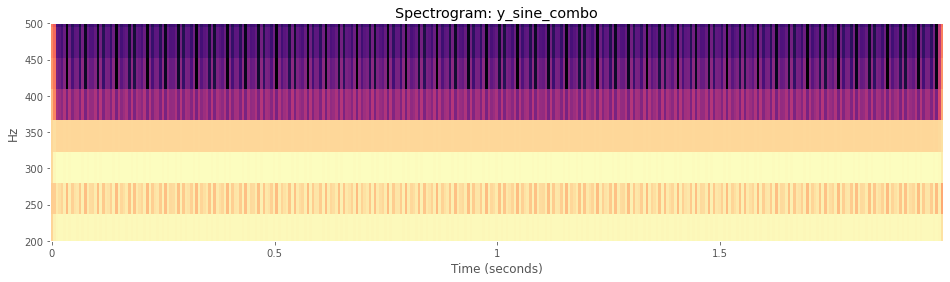

In [55]:
## Let's try out the function
fig, ax = plot_spectrogram(y_sine_combo, sr)

## We can still do things to the axis 'ax' that we got as output of the function
ax.set(title='Spectrogram: y_sine_combo')

## Our combo wave is made up of sine waves with frequencies all less that 1000 Hz, 
## so let's zoom into to those frequencies:
ax.set(ylim=[200, 500])

### Spectral Leakage 

You should see that there are some bright lines around 100, 200 and 300 Hz but also on the surrounding frequencies.  How can that be if our input wave was only made of those three frequencies?


**Question**: Can you explain what's happening here?  Start by calculating what the actual DFT analysis frequencies should be.
Remember, you can do this if you know:
* the sampling rate
* the number of samples per frame


In [65]:
## print out the sampling rate of y_combo_sine
print(f"The sample rate of y_combo_sine is {sr}Hz")

The sample rate of y_combo_sine is 22050Hz


In [66]:
## print out the lowest analysis frequency that can be captured by the DFT given the input length
## in samples (512 in this case) and the sampling rate (sr) of the recording. 

print(f"The DFT output frequencies are multiples of {(sr/N):.10f}Hz")


The DFT output frequencies are multiples of 43.0664062500Hz


### Analysis frequencies and Leakage
You should find that the lowest analysis frequency for a sample rate of 22050 Hz and an window size of 512 samples is 43.07 Hz. So, the analysis frequencies captured by the DFT in this case are the integer multiples of that up to the Nyquist Frequency. This means that 100Hz, 200Hz, and 300 Hz all fall between the analysis frequencies. So, their "presence" in the input ends up getting "leaked" onto (i.e. represented by) surrounding analysis frequencies.  

For our specific case the closest analysis frequencies are 86.13, 215.33, 301.46, etc, but we also see positive magnitudes in the spectrum at other nearby frequencies.  

How and when this happens is effected the **windowing functions** we apply to input windows (i.e. frames) before applying the DFT. We won't go into it much in this course, but suffice to say there's a reason there are [so many window functions](https://docs.scipy.org/doc/scipy/reference/signal.windows.html) that have been proposed for different tasks! 



**Optional Task:** can you find a window size (in number of samples) that will give you whole number analysis frequencies and also a decent number of samples?  

Generate a sine wave that is exactly one of these analysis frequencies.

Hint: here are some factors of 22050: 1, 2, 3, 5, 7

In [ ]:
## We get an whole integer analysis frequencies if our DFT input size is ????


Let's see what happens when we try with a combination of $N=450$ and input frequency $f=147$, since 147 Hz should be an analysis frequencies for $N=450$ and a sampling rate of 22050 Hz.

We use the numpy function `linspace` below to get a specific number of samples (`sr*T`), evenly spaced between `0` and and `T`. So if T=1 second we get 22050 samples. 

[(0.0, 0.1),
 Text(0.5, 0, 'Time (s)'),
 Text(0, 0.5, 'amplitude'),
 Text(0.5, 1.0, 'A 147 Hz sine wave')]

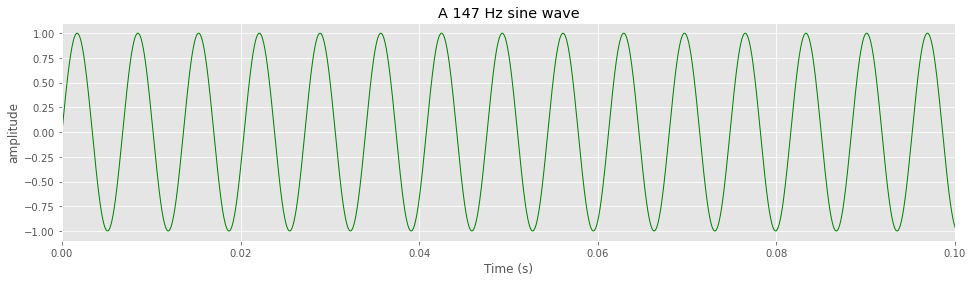

In [67]:
# make a 1 second sine wave with frequency f=147 Hz
T = 1 ## max time
sr  = 22050 ## sampling rate
f = 147  ## sinusoid frequency

## make the time samples, we want sr*T samples evenly space from time 0 to T
time_samples = np.linspace(0, T, int(sr*T), endpoint=False)

## get the sine wave amplitudes for a frequency f for the time samples we want
## We can use numpy's built in sin function for this
xs = np.sin(2 * np.pi * f * time_samples)

## make a plot
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(time_samples, xs, linewidth=1, color='green', label='wav')
ax.set(xlim=[0,0.1], xlabel="Time (s)", ylabel="amplitude", title="A 147 Hz sine wave")


In [68]:
## Let's listen (147 Hz)
display(Audio(data=xs, rate=sr))

### Effect of the windowing function 

Now, if we choose the window size such that the input sine wave frequency is one of the DFT analysis frequencies, we get less leakage: But the amount depends on the windowing function. Let's first try the default, which is the **Hann** window (a generally good all-purpose windowing function)

[Text(0.5, 1.0, 'Spectrogram of a f=147 Hz sine wav, windows size N=450 samples, Window type = Hann'),
 (0.0, 500.0)]

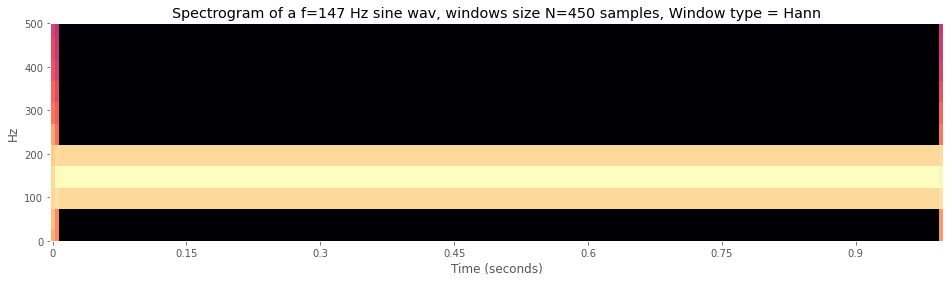

In [69]:
## plot the spectrogram with N=450 as the size of the input to the DFT (in samples) 
## and using the "hann" window: this tapers the edges of the window
N=450
fig, ax = plot_spectrogram(xs, sr=sr, n_fft=N, window_type="hann")
ax.set(title=f'Spectrogram of a f={f} Hz sine wav, windows size N={N} samples, Window type = Hann', ylim=[0, 500])

Not bad! But we're still still seeing leakage! It turns out that [this a property of the Hann windowing function](https://brianmcfee.net/dstbook-site/content/ch06-dft-properties/Leakage.html): if you apply this windowing function to your input and your input is one of the analysis frequencies, it'll give you some leakage! 

In this case, our problem goes away if you use a rectangular or 'boxcar' window which is equivalent to no window at all. 

[Text(0.5, 1.0, 'Spectrogram of a f=147 Hz sine wav, windows size N=450 samples, Window type = boxcar (rectangle)'),
 (0.0, 500.0)]

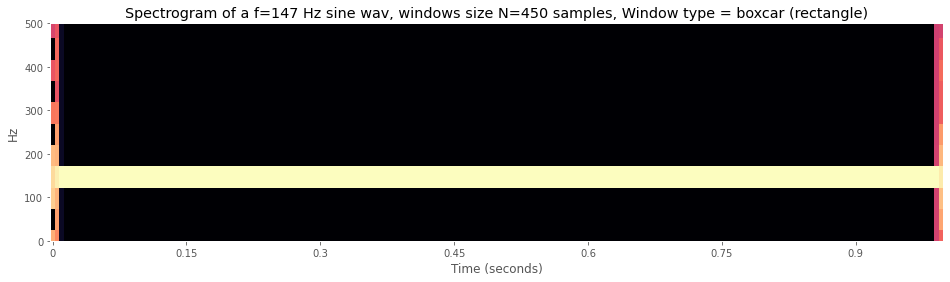

In [70]:
fig, ax = plot_spectrogram(xs, sr=sr, n_fft=450, window_type="boxcar")
ax.set(title=f'Spectrogram of a f={f} Hz sine wav, windows size N={N} samples, Window type = boxcar (rectangle)', ylim=[0, 500])

Now we seem to have gotten rid of the leakage (at least away from the waveform edges). 

Does this mean we should just use a rectangular window? Well, no.  It turns out, for speech processing at least,  the advantages of using the Hann shaped window for reducing the amount of leakage overall is outweight the loss of precision for the specific DFT analysis frequencies.  In general, we are more interested in getting a good estimate of the overall shape of the spectrum rather than specific single frequencies.  However, this isn't the case for all signal processing applications.

Librosa allows you to use any of the [windowing functions implemented in the scipy package](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.get_window.html#scipy.signal.get_window).  Feel free to try them out to see what they do! You can actually just think of these windowing functions as a type of filter - more on this in module 4!



# Sampling and Aliasing

So far, we've kept with a standard sampling rate, 22050 Hz. What happens if we want to reduce the sampling rate?  This happens a lot for applications like ASR where machine learning models are trained expecting 16kHz and sometimes even 8KHz input. 

What happens if we just downsample but reducing the number of samples? 

## Naive downsampling 

Here's a somewhat naive strategy for for downsampling: 
If I have N samples per second, and only want M samples per second, I just take every 
N/Mth one. 
For example,
* If I have 100 samples and I only want 20, then just take every 100/20 = 5th one
* If my sampling rate is 22050 but I only want 8000 of them per second, then I take every 22050/8000th of the original samples

Let's try down sampling from our original 22050 Hz to 8000 Hz for the "frequency sweep" recording. 

In [71]:
## Set the sampling rate of the original recording, orig_sr to 22050 Hz
orig_sr = 22050

## Set the target sampling rate, target_sr to 8000 Hz
target_sr = 8000

## Let's try this out on the sweep wave
## You can also try adding in the other sine waves to see what happens to them
ys = y_sweep

## Find the indices of the samples that we want to keep 
## This is N/M in the text above
k = round(orig_sr/target_sr)

## Make a list of multiples of k between 0 and the number of samples in y
## These are the samples we want to keep after downsampling

downsample_index = np.arange(0, len(ys), k)
y_ds = ys[downsample_index]
Audio(y_ds, rate=target_sr)

Something weird has happened to the sweep sound! It seems to go up in frequency and then down again, when before it just went up. This is aliasing! 

Let's look at the spectrogram to verify: 

[Text(0.5, 1.0, 'Spectrogram: Frequency sweep, downsampled to 8000 Hz (originally 22050 Hz)')]

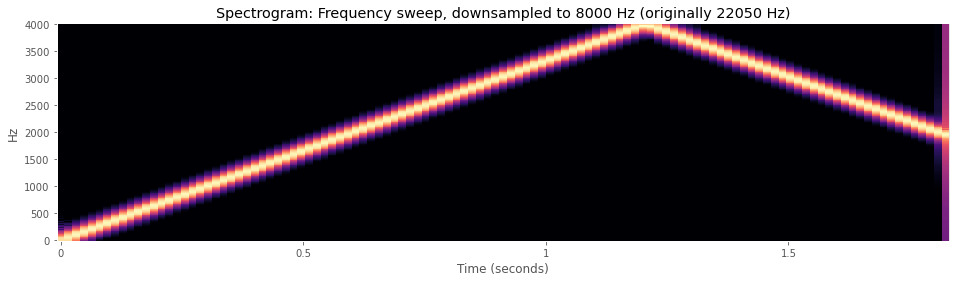

In [72]:
fig, ax = plot_spectrogram(y_ds, sr=target_sr, n_fft=512)
ax.set(title='Spectrogram: Frequency sweep, downsampled to 8000 Hz (originally 22050 Hz)')



You should see that the sweep frequencies in the spectrogram start to go down again after 4000 Hz, i.e. half the target sampling rate, the Nyquist Frequency. 

<div class="alert alert-success" role="alert">
For N input samples, The DFT outputs represent N frequencies evenly spaced between 0 Hz and the sampling rate, but we can only actually analyze frequencies up to half the sampling rate (i.e., the Nyquist Frequency) 
</div>

Let's plot the waveform for another view of what's happening. 

**Task:** You can change the `xlim` values to zoom in to see what is happening at different parts of the recording. 


[(0.1, 0.2)]

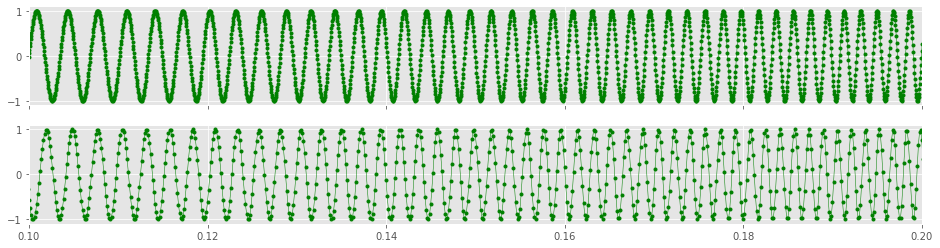

In [73]:
## Get the time samples based on the original sampling rate, by creating an
## array of sample indices from 0 to the length of ys (the number of samples in the recording)
## Get the time stamps by multplying this array of indices by the sampling period

original_time_samples = np.arange(0,len(ys)) * (1/orig_sr)

## Similarly, get the time stamps based on the target sampling rate
target_time_samples = np.arange(0,len(y_ds)) * (1/target_sr)

## Plot both the original waveform and the downsampled one, linking the x-axis for both to be shared
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(16,4), sharex=True)
axs[0].plot(original_time_samples, ys, linewidth=0.5, color='green', marker=".", label='original wav')
axs[1].plot(target_time_samples, y_ds, linewidth=0.5, color='green', marker=".", label='downsampled wav')

## Set x-axis to zoom in on a specific part of the waveform 
axs[0].set(xlim=[0.1, 0.2])



You should see that at the beginning of the waveforms, the sine waves are fairly matched even if there they are not perfectly aligned due to the very naive way we sampled and then reconstructed the time steps for the downsampled version.  

Further along in time you'll see that the downsampled sinusoid starts to look abit rough, and after it hits the 4000 Hz, the wave for the downsampled version starts to look like the "mirror" frequency of the original wave (e.g. 4500 Hz in the original looks like 3500 Hz in the downsampled version). 

This is the heart of aliasing: with the lower sample rate we just can't sample fast enough to capture frequencies higher than the Nyquist frequency. Instead we get something that looks like a lower frequency than it actually should be.  

This means that if we have frequencies that are higher than half the sample rate in our original sounds when recording, they will still be captured but at the incorrect frequency!  If we want to avoid this we need to remove those higher frequencies before doing any other processing (using filtering).  This is what a "real" resampling algorithm would do.

The following cell applies [librosa's resampling function](https://librosa.org/doc/latest/generated/librosa.resample.html#librosa-resample) to our sine wave combo plus the sweep.  You'll hear that the lower frequency sine waves are preserved, but the sweep just disappears after it hits 4000 Hz.  



In [74]:
target_sr=8000
y_resample = librosa.resample(y_sine_combo +y_sweep, orig_sr=orig_sr, target_sr=target_sr)
display(Audio(data=y_resample, rate=target_sr))

[Text(0.5, 1.0, 'Spectrogram: sine waves and sweek resampled by librosa')]

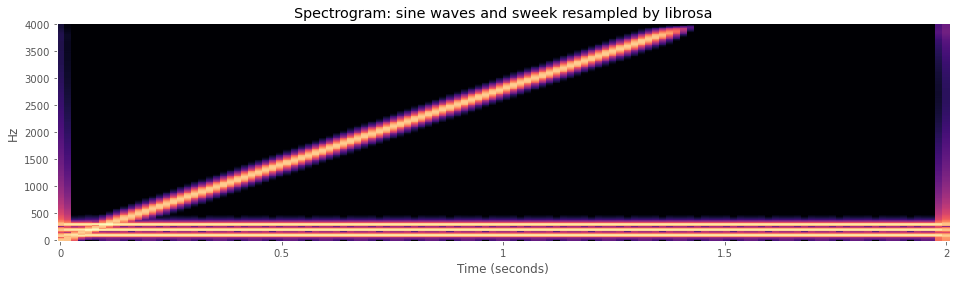

In [77]:
fig, ax = plot_spectrogram(y_resample, sr=target_sr, n_fft=512)
ax.set(title='Spectrogram: sine waves and sweek resampled by librosa')
## what are the three horizontal lines?

# Phase Shifts

So far, we've just been focusing on the magnitude spectrum and sine waves. However, if you look at the raw DFT output (before taking the absolute value) you'll find that it also includes phase information. 

Your default sine wave has the form $sin(2\pi f t)$ where $f$ is the frequency of the sine wave and $t$ is the time we want to get the amplitude for.  

A phase shift tells us to shift the starting point of the sinusoid by some amount, usually expressed in terms of an angle, $\theta$.  This looks like:  $sin(2\pi f t + \theta)$. 

It's easier to see this visually, so let's generate some sine waves with and without phase shifts.  First, let's make a function to generate sine waves of different frequencies. 

In [76]:
## a function to generate sinusoids, potentially with phase shifts 
def gen_sine_wave_with_phase_shift(frequency, phase_angle=0, sample_rate=22050, duration=1.0):
    ## calculate times for samples given sample rate and specified duration
    time_samples = np.linspace(0, duration, int(sample_rate*duration), endpoint=False)

    ## Generate amplitudes for a sinusoid of the specific frequency and phase shift for those time steps
    amplitudes = np.sin(2 * np.pi * frequency * time_samples + phase_angle)

    ## Return both the time steps and the amplitudes
    return time_samples, amplitudes

Let's generate and plot some sine waves using the function above:

**Question:** If we generate sine waves of the same frequency, but different phase shift, will they sound different?

Nope.

x1: 300 Hz, 0 radians phase shift


x2: 300 Hz, 0.33 radians phase shift


x1 + x2


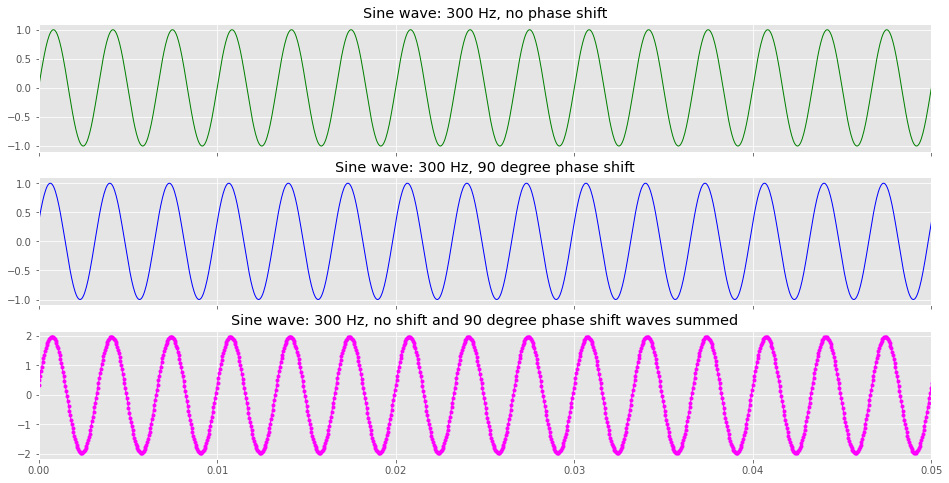

In [92]:
# Varying the phase of one of the sinusoids changes the look of the wavform but not the how it sounds

sr = 22050 ## sampling rate

## generate amplitudes for a sine wave of frequency 300Hz with no phase shfit
f1=300
theta1=0
ts, x1 = gen_sine_wave_with_phase_shift(frequency=f1, phase_angle = theta1, sample_rate=sr)

## generate amplitudes for a sine wave of frequency 300Hz with a pi/2 = 90 degree phase shift
f2=300
theta2=np.pi/2
ts, x2 = gen_sine_wave_with_phase_shift(frequency=f2, phase_angle = theta2, sample_rate=sr)

## Plot x1 and x2 sinusoids as well as x1+x2, so they all share x-axis parameters
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(16,8), sharex=True)
axs[0].plot(ts, x1, linewidth=1, color='green', label='wav')
axs[1].plot(ts, x2, linewidth=1, color='blue', label='shifted')
axs[2].plot(ts, x1+x2, linewidth=1, color='magenta', marker=".", label='summed')

## Set x-axix parameters - change xlim to zoom into different parts of the waveform
axs[0].set(xlim=[0,0.05])
axs[0].set(title="Sine wave: 300 Hz, no phase shift")
axs[1].set(title="Sine wave: 300 Hz, 90 degree phase shift")
axs[2].set(title="Sine wave: 300 Hz, no shift and 90 degree phase shift waves summed")

print(f"x1: {f1} Hz, {theta1} radians phase shift") 
display(Audio(x1, rate=22050, normalize=False))

print(f"x2: {f2} Hz, {theta2:.2f} radians phase shift") 
display(Audio(x2, rate=22050, normalize=False))

print(f"x1 + x2") 
display(Audio(x1+x2, rate=22050, normalize=True))


You should see that the sine wave with no phase shift starts at time $t=0$ with an amplitude of zero that then regularly rises up and down.  

The phase shifted sine wave (middle figure) instead starts at 1, i.e. as if we had shifted 1st sine wave to the left.  This 90 degree phase shifted sine wave is actually equivalent to a cosine wave.  

Actually, technically the DFT deals with cosine waves not sine waves but this only affects the phase spectrum, not the magnitude spectrum so we often use the two interchangeably (it does matter if you're trying to interpret the phase spectrum though!).  

If we add the two sine waves together (bottom figure), we see that we still get a sine wave of the same frequency but it has a different phase shift again (something between the two we started with).  However, if you listen to the audio for the three sine waves they sound pretty much the same. This perceptual invariance is the primary reason we focus on the magnitude spectrum in speech processing.  

**Tasks:** try changing the phase shift in the code above to see the relationship between the period of the sine waves and the phase angle.  
* It's easiest to do this in radians where: $2\pi$ radians equals 360 degrees (so $\pi/2$ radians = 90 degrees).
* What happens when the phase shift is 360 degrees? How about 720 degrees ($4\pi$ radians).
* What happens if you give it a negative phase angle?  

**Question:** What happens to the combined wave if you change the second sine wave to be very close but not quite the same as the first sine wave (e.g. 300 vs 310 Hz)? 


In [94]:
# A: looks like two 300Hz adding together.
# Why not mentioning 180 degrees here?

## Sine waves and complex sinusoids

It can be easier to understand why we talk about phase angles if we look a bit more at what a sine wave actually represents. It's the vertical projection of a rotation of a point around the a circle centred a (0,0).  

This is visualised in the following animation, where the **amplitude** of the sine wave matches the **height** of the point as it goes around the circle (the blue dot). 

![Complex sinusoid to cosine and sine wave gif](../fig/phasor.gif)

You can see that one complete period of the sine wave corresponds to a 360 degrees around the circle: ending up back where we started at (1,0).  A phase shift of 90 degrees is the same as starting the "clock hand" on the circle after rotating it 90 degrees from the starting point. 

A cosine wave is the horizontal projection of the same circle (not shown here). You can determine these vertical and horizontal projection using good old trigonometry (though we won't ask you to do this in class!).

Increasing the frequency of the sine wave is equivalent to going around the circle faster - we make more cycles in the same amount of time.  

# Extension: What is the DFT really? 

<div class="alert alert-warning">
The details in this section about the use of the complex numbers in the DFT are not examinable, but are really just a starting point for further understanding, as well as the details you'd need to actually implement this yourself (which you can do!). 
</div>

The description of the DFT in this course has, thus far, been quite high level and mostly focused on the magnitude spectrum.  We don't really need you to get into all the details of the DFT but it's worth knowing a bit about what the DFT actually outputs, and how it's possible to get both phase and magnitude information from the DFT.  In fact, if you use an off-the-shelf DFT function, like the `fft` function from `numpy`, or the `stft` function from `librosa`, you will get phase and magnitude information out in the first instance, whether you want it or not.  This is why we had to apply the `np.abs` absolute value function before plotting the spectrogram above. 





## The DFT: Waveforms in, complex numbers out

The thing that we have been skirting around about the DFT is that it's out is actually a set of complex numbers.  That is, numbers of the form $a+ib$ where $i=\sqrt{-1}$.  In fact, this is what the 2-D plane on the left of the animation represents: the complex plane.  Each complex number is represented by a 'real' part $a$ and and 'imaginary' part $b$.  

When we do the DFT we're actually calculating the similarity between our input waveforms and sinusoids in the complex plane. Because of this, the outputs of the DFT end up being a sequence of complex numbers.  This is why if you look in Jurafsky and Martin, or other textbooks you'll see the DFT defined as: 

* **Input:**  $N$ amplitude samples over time 
    * $x[n]$, for $n=0..N-1$ (i.e. a time series of $N$ samples)
    
    
* **Output:** the dot product (i.e., the similiarity) between the input and $N$ complex sinusoids with different frequencies
    * DFT[k] $= Me^{-j\phi}$, i.e. a complex number (in polar form) with **magnitude** $M$ and **phase** angle $\phi$
    * The $N$ DFT outputs represent $N$ equally space frequencies between 0 and the sampling rate.

     
Where the outputs are calculated using the following formula for $k=0,...N-1$. 
$$ 
\begin{align}
DFT[k] &= \sum_{n=0}^{N-1} x[n] e^{-i \frac{2\pi n}{N} k} \\
\text{ or equivalently, } DFT[k] &= \sum_{n=0}^{N-1} x[n]\big[\cos(\frac{2\pi n}{N} k) - i \sin(\frac{2\pi n}{N} k) \big] 
\end{align}
$$

That is the output is, N complex numbers from which we extract magnitude and phases of specific complex sinusoids.  The key here is that terms of the form $M e^{-i\theta}$ are a nifty way to express complex numbers, and from which we can easily read of magnitude ($M$) and phase angle ($\theta$).   

For the Speech Processing course we don't expect you to get into the details of this or calculate the DFT yourself.  But it is important to know that when you apply the `stft` of `fft` functions in python packages, you'll get complex numbers as output.  To get the magnitude spectrum you'll need to take absolute values of those DFT outputs.  

It's all actually very neat and if you want to learn more there are some other notebooks here that go through the DFT in more detail. But you can see this for yourself by trying out the [fft](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html#numpy.fft.fft) function from the numpy package (which is what the librosa spectrogram generator uses by default). 



In [95]:
## import numpy's fft function
from numpy.fft import fft

## Set the sampling rate to 8000 Hz
sr = 8000

## Create a sine wave of frequency 300 Hz and no phase shift, sampled at sr Hz
ts, xs = gen_sine_wave_with_phase_shift(frequency=300, phase_angle = 0, sample_rate=sr)

## Set the size of the DFT input window to N=80 samples
N = 80

## Get a window consisting of the first 0 to N samples from our waveform
current_window = xs[0:N]

## Apply the fft (the "fast" version of the DFT) to the window of N samples
dft_outputs = fft(current_window)

## print the output shape of the dft output, check the number of output values is the same as N
print(f"The DFT output shape is {dft_outputs.shape}")

The DFT output shape is (80,)


In [96]:
## inspect the dft outputs
dft_outputs

array([-5.40576569e-15+0.00000000e+00j, -3.80908542e-15-4.44089210e-16j,
       -2.27633865e-16-1.76931549e-16j, -1.28018919e-14-4.00000000e+01j,
        2.69723254e-15-5.40796348e-15j,  3.76371548e-16-1.38955260e-15j,
       -3.29539840e-15+1.11338877e-15j, -1.81703549e-15-6.26855228e-15j,
        9.53494130e-16-1.66994468e-15j,  2.34746327e-17-4.63109139e-15j,
        9.54924107e-16-9.91748167e-16j,  2.77300046e-15-1.25272175e-15j,
       -1.00806675e-15+1.63340361e-15j, -4.78416342e-16-3.55271368e-15j,
        1.14564746e-15+3.23202975e-16j, -2.27286297e-15-1.57445078e-17j,
        2.74590943e-15+2.30218784e-16j, -3.29696177e-16+2.70792998e-15j,
       -6.29152745e-15-1.19947172e-15j,  9.22698680e-16-1.99960241e-15j,
       -2.15836334e-15-5.57887070e-15j, -2.47681779e-15-2.44249065e-15j,
        4.72766426e-15-3.81221364e-15j,  9.09362439e-16+1.88737914e-15j,
       -3.57713070e-15-1.52151211e-15j,  5.46164737e-16-7.79921974e-16j,
        4.68538540e-16-5.34902463e-15j, -1.37428358

Yikes! That's not exactly easy to read! It can be easier to see what's happening with these complex numbers if we plot the outputs in the complex plane, so let's try that. 



** DFT outputs with positive magnitude**

dft_outputs[3] = -0.00 + -40.00i
	* magnitude=40.00, angle=-1.57 radians
	* angle in degrees = -90.00
	* Analysis frequency = 300.0 Hz


dft_outputs[77] = -0.00 + 40.00i
	* magnitude=40.00, angle=1.57 radians
	* angle in degrees = 90.00
	* Analysis frequency = 7700.0 Hz




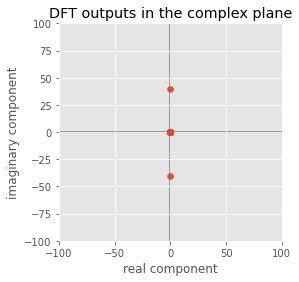

In [97]:
## Set up a square plot (4,4)
fig, ax = plt.subplots(figsize=(4,4))

## Set the axes limits, title, and axis labels
ax.set(xlim=[-100,100], ylim=[-100,100], title="DFT outputs in the complex plane", xlabel="real component", ylabel="imaginary component")

## Plot horizontal and vertical lines through (0,0) just for reference
ax.plot([-200,200], [0,0], color='grey', zorder=0)
ax.plot([0,0],[-200,200], color='grey', zorder=0)

## Plot our dft outs with the real component on as the x-axis value, and the the imaginary (i) component on the y-axis
## Note python uses "j" to represent the imaginary number, but you'll see it as "i" in most maths textbooks

ax.scatter(dft_outputs.real, dft_outputs.imag, zorder=10)

## print out formatted versions of the DFT outputs, only if the magnitude is greater than zero
print("** DFT outputs with positive magnitude**\n")

## iterate over each dft output index k, and the output value val,
for k, val in enumerate(dft_outputs):

    ## Check if the current magnitude is greater that zero
    ## There are computational issues with representing zeros and very small numbers here, so we'll just approximate
    ## zero here with a very small number.
    magnitude = np.abs(val)
    if np.abs(val) > 0.0000000001:
            ## get the phase angle in radians
            angle=np.angle(val) 
            
            ## convert it to degrees
            angle_in_degrees= 360*angle/(2*np.pi)

            ## get the analyses frequency represented by this DFT output
            analysis_frequency = k * (sr/N)

            ## Print out the dft output value in a+bi format, as well as magnitude and angle
            print(f"dft_outputs[{k}] = {val.real:.2f} + {val.imag:.2f}i")
            print(f"\t* magnitude={magnitude:.2f}, angle={angle:.2f} radians")
            print(f"\t* angle in degrees = {angle_in_degrees:.2f}")

            ## Print out the analysis frequency
            print(f"\t* Analysis frequency = {analysis_frequency} Hz\n\n")

## The DFT outputs and Aliasing

You should see here that we found 2 DFT outputs with non-zero magnitude that corresponding to 300 Hz and 7700 Hz sine waves. 
Since our sampling rate was 8000 Hz, we can only capture frequencies up to 4000 HZ. The 7700 Hz component is basically due to aliasing. 

We won't go through the details in this course, but it is worth knowing that if you look at the full DFT output spectrums (e.g. using the numpy `fft` function) you will see this sort of mirroring.  If your input has a component of $f$ Hz, you'll also positive magnitudes for $f$ and $f_s - f$, where $f_s$ is the sampling rate  (e.g., 300Hz, and 7700Hz = 8000-300Hz in the example above.). These mirrored components above the Nyquist frequencies are misleading if you just want to know what frequency components are in your input, which is why we usually discard the upper half of the DFT output.  However, they are necessary if you want to reconstruct the a waveform from the magnitude and phase spectrums (i.e., the _Inverse_ Discrete Fourier Transform).  

One more thing to note here is that we see phase angle for the 300 Hz component is -90 degrees. This is because DFT phase shifts are determined relative to cosine waves (which are just sine waves shifted by 90 degrees). 

If you want more details on this and the mechanics of the DFT in general, you can check out the extension notebooks or [this very nice set of lecture notes by Brian McFee](https://brianmcfee.net/dstbook-site/content/ch05-fourier/intro.html). 



# Practice Exercises


1. We have an input of waveform made of 3 sine waves: 100 Hz, 200 Hz, 300 Hz.  The sampling rate $f_s$ is 8000 Hz and number of samples in each frame (i.e. window) is $N=80$. Let's say you put this through the DFT.  
* Looking at the _complete_ DFT output, what analysis frequencies would the 80 DFT outputs theoretically represent?
* Which of those 80 frequencies can we actually accurately capture? Why?
    * Another way to think about it: of those frequencies which would we usually see plotted on a spectrogram? 
* Out of the analysis frequencies we can capture, which will show positive (i.e. non-zero) magnitudes in the magnitude given our input?

2. Now, instead assume that the number of samples $N$ is 100:
    * What are the DFT analysis frequencies now?
    * Does using this larger input window $N$ give you better frequency resolution? How about time resolution?  
    * Which frequencies do you expect will show positive magnitudes given that the window is take from the same input as before?  

3. Assume the sampling rate of your waveform is 16000 Hz (instead of 8000 Hz), and your input window is 80 samples.
    * What is the range of frequencies you can now capture with the DFT?
    * What is the number of analysis frequencies?
     
4. Assume your sampling rate is 16000 Hz, and your input window size is 100 samples
    * What's the length of your input window in seconds?
    * What will the DFT show if your input a window from a waveform made up of a 320 Hz component, and a 8640 Hz component, assuming you don't do any pre-filtering of the input?


1. 
* 100Hz multiples, [0, 100, 200, ..., 7900]Hz
* [0, 100, 200, ...4000]Hz
* all three

2. 
* 80Hz multiples, [0, 80, ..., 7920]Hz
* higher frequency resolution, lower time resolution.
* all three

3. 
* 0-8000Hz
* 41

4. 
* 100/16000 6.25ms 
* 160Hz multiples, both will be shown. but 8640Hz > Nyquist Frequency, will be recognized as 7360Hz


# More on the DFT

You can find some more notebooks that go through the DFT in more detail here in the extension material here:

* [Complex numbers and sinusoids](./extension/signals-1-ext-1-digital-signals-complex-numbers.ipynb)
* [Digital Signals: Sampling sinusoids](./extension/signals-1-ext-2-sampling-sinusoids.ipynb)
* [The Discrete Fourier Transform](./extension/signals-1-ext-3-discrete-fourier-transform-in-detail.ipynb)
* [More on Interpreting the DFT](./extension/signals-1-ext-4-more-interpreting-the-dft.ipynb)

As mentioned above, some other good resources are 
* [Digital Signals Theory by Brian McFee](https://brianmcfee.net/dstbook-site/content/ch05-fourier/intro.html)
* [Seeing Circles, Sines and Signals by Jack Schaedler](https://jackschaedler.github.io/circles-sines-signals/index.html)

# Extra! Plotting speech

This lab has focused on relatively simple audio examples to focus on foundational aspects of digital signal processing.  But at the end of the day we want to use this to visualise and analyse speech. So, let's see if we can make a Praat-like plot here. It's completely fine to just use Praat plots for the assignments, but if you prefer using python you may find this handy for this or other courses. 

First, Let's load in the TTS sample from the module 1 lab and plot a spectrogram: 

In [98]:
## Load the file from lab 1: speechproc_phonlab1_2.wav
y_awb, sr = librosa.load('../../phon/phon_lab_1/speechproc_phonlab1_2.wav')

## Make and audio widget to play it
display(Audio(y_awb, rate=sr))                         

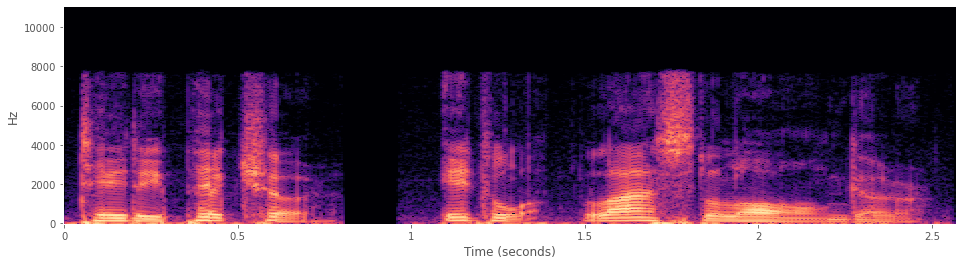

In [99]:
## Plot the spectrogram of the audio you just loaded and check it's what you expected
fig, ax = plot_spectrogram(y_awb, sr=sr, n_fft=512)

In [100]:
## Print out the sampling rate to check it's what you expect
print(f"The sampling rate is: {sr} Hz")

The sampling rate is: 22050 Hz


## Dealing with textgrids
We can read in textgrid information using a package like `praatio`.  But we need to install it first: 

In [101]:
!pip install praatio 


Defaulting to user installation because normal site-packages is not writeable


Now, we'll import the textgrid class from `praatio`.  We'll also use the `pandas` package to make some data frames (i.e., tables) to make life easier.  If you're familiar with R, you'll probably find pandas data frames to be somewhat familiar!  

Then we can read in an existing textgrid file that has words annotated on a word tier.


In [102]:
## import the textgrid class from praatio
from praatio import textgrid

## import pandas and give it a shortname "pd" which we can use to refer to it
import pandas as pd

## read in the textgrid using the function textgrid.openTextgrid from praatio
tg = textgrid.openTextgrid("speechproc_phonlab1_2.TextGrid", includeEmptyIntervals=True) 

## Get the word tier uing the getTier function
words = tg.getTier("words")

## inspect the output of getTier from the previous step
words    


In [103]:
## convert the words tier entries into a dataframe
wordsdf = pd.DataFrame(words.entries)

## add a column that's the midpoint in time for each of the words
## we'll use this for plotting later
wordsdf.loc[:,'midpoint'] = (wordsdf.end + wordsdf.start)/2

## output the table
wordsdf

,start,end,label,midpoint
0,0.000000,0.043552,,0.021776
1,0.043552,0.214112,take,0.128832
2,0.214112,0.293707,a,0.253910
3,0.293707,0.805388,picture,0.549547
4,0.805388,1.085107,,0.945247
5,1.085107,1.405760,it'll,1.245433
6,1.405760,1.849217,last,1.627488
7,1.849217,2.463234,longer,2.156225
8,2.463234,2.568188,,2.515711


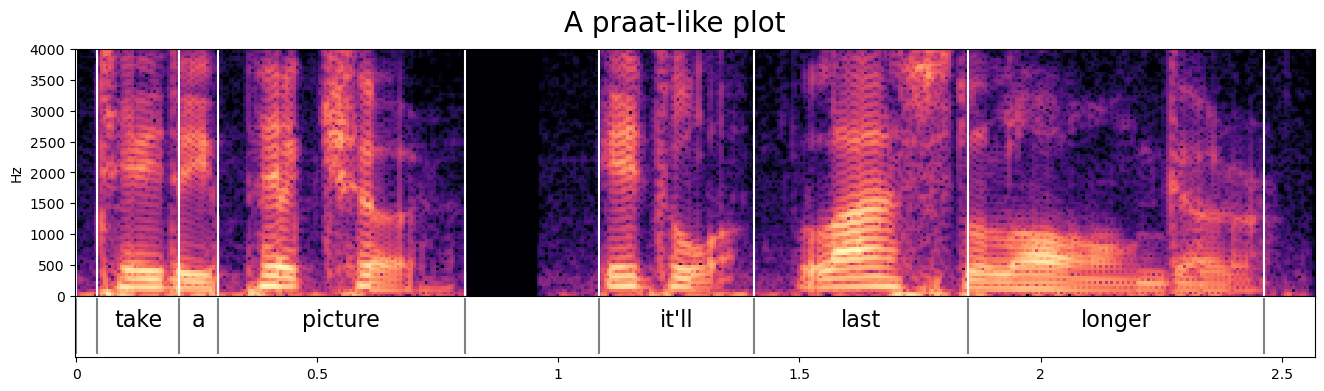

In [104]:
## Use the default matplotlib style with a white background and no grid lines
plt.style.use('default')

## we want to be more specific with the layout here so we'll set it up in more steps
## First start of the figure with just the overall size
fig = plt.figure(layout=None,  figsize=(16,4))

## Add the title
fig.suptitle('A praat-like plot', horizontalalignment="center", fontsize=20)

## Specify the layout as a grid, with no vertical space between the subplots
gs = fig.add_gridspec(nrows=5, ncols=1,  hspace=0.0, wspace=0.05)

## Add the first subplot to span all but the last row of the grid
ax_spec = fig.add_subplot(gs[:-1, :])

## get the spectrogram info, with DFT inputs of 512 samples
N=512
window_type="hann"
S = np.abs(librosa.stft(y_awb, n_fft=N, window=window_type))

## Plot the spectrogram in the first subplot, ax_spec
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), sr=sr, hop_length=N//4, 
                         y_axis='linear', x_axis='s', ax=ax_spec)

## Plot vertical lines at the word boundaries
ax_spec.vlines(x=wordsdf['start'], ymin=0, ymax=10000, color="white")

## Add another subplot for the word tier from the text grid
## set the x-axis to be the same as ax_spec
ax_words = fig.add_subplot(gs[-1, :], sharex=ax_spec)

## Remove y-axis ticks
ax_words.set(yticks=[])

## A vertical lines at the word boundaries
ax_words.vlines(x=wordsdf['start'], ymin=0, ymax=1000, color="grey")

## For each row of our word dataframe, plot the word at midpoint time of the word interval
for i, row in wordsdf.iterrows():
    ax_words.text(x=row['midpoint'], y=500, s=row['label'], color="black", fontsize=16, horizontalalignment="center")

ax_spec.set(ylim=[0,4000])

## Get reid of x-axis ticks for the spectrogram subplot
_ = plt.setp(ax_spec.get_xticklabels(), visible=False)
#ax0.set(xticks=[])
#ax1.set_xlim(ax0.get_xlim())



And there it is! 

**Very optional:** try to add more elements to the plot, e.g. the waveform at the top in another subplot, or an F0 contour.  

<div class="alert alert-warning">
Warning: matplotlib formatting can very much be a rabbithole and/or time sink! It can be fun to work on visualisations but again, it is perfectly fine just to use the plotting functions in Praat!
</div>

## Notes

_You can use this space to make notes!_